## **Notebook PC#01**
## Regularized Linear Classifier for the MNIST database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt <br>


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data() # loading the MNIST dataset
Xa = Xp.reshape(Xp.shape[0], 784) # flatten 28x28 training images (784 vector)
Xta = Xtp.reshape(Xtp.shape[0], 784) # flatten 28x28 testing images (784 vector)

Xa = Xa / 255.0 # normalizing [0,1] range
Xta = Xta / 255.0 # normalizing [0,1] range

X0 = np.ones((Xp.shape[0],1)) # creating the bias matrix
X = np.hstack((X0,Xa)) # concatenating bias term to the data
Xt0 = np.ones((Xtp.shape[0],1))
Xt = np.hstack((Xt0,Xta))

print("Shape of X (training): ".ljust(10),  X.shape)
print("Shape of y (training): ".ljust(10),  y.shape)
print("Shape of Xt (testing): ".ljust(10),  X.shape)
print("Shape of yt (testing): ".ljust(10),  yt.shape)

2024-04-01 14:32:12.522590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 14:32:12.571058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 14:32:12.571099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 14:32:12.572283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 14:32:12.580010: I tensorflow/core/platform/cpu_feature_guar

Shape of X (training):  (60000, 785)
Shape of y (training):  (60000,)
Shape of Xt (testing):  (60000, 785)
Shape of yt (testing):  (10000,)


In [3]:
# Visualizing a random data point
import plotly.express as px

ind = np.random.randint(60000)
print('Data point: ', ind, '\n', 'Label: ', y[ind]) # y[ind] is a label from 0 to 9
fig = px.imshow(255-Xp[ind], binary_string=True, width=200, height=200) # plotting a grayscale image
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
fig.show()

Data point:  44393 
 Label:  2


In [28]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y) # "to_categorical" function is creating an one-hot encoded categorical representation
print ("(One hot encoding) yy[0]: ", yy[0], " // (Original label) y[0]: ", y[0])
yyt = to_categorical(yt) # "to_categorical" function is creating an one-hot encoded categorical representation
print ("(One hot encoding) yyt[0]: ", yyt[0], " // (Original label) yt[0]: ", yt[0])
sum_along_columns1 = np.sum(yy, axis = 0) # Sum the one-hot encoding matrix gives the total of samples per label (training data)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0) # Sum the one-hot encoding matrix gives the total of samples per label (testing data)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

(One hot encoding) yy[0]:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  // (Original label) y[0]:  5
(One hot encoding) yyt[0]:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]  // (Original label) yt[0]:  7
[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [29]:
partition = 0.7 # 70% of the dataset is gonig to be used as training data

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

X_training:          (42000, 785)
y_training:          (42000, 10)
X_validation:        (18000, 785)
y_validation:        (18000, 10)


In [6]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [7]:
def get_w(X, y, c): # get weight (L2/Ridge regularization)
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1])) # (X^T * X)
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [30]:
print("X.shape[1]: ", X.shape[1])

X.shape[1]:  785


In [54]:
def get_rates_from_c_values(X, y, c_values, Ws = []): # Ws is a list that stores the weight vectors (W) calculated for different values of the regularization parameter c (c_values)
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [48]:
c_values = [pow(2,d) for d in range(-10, 19, 2)] # Range goes up to 19 to ensure search up to 2^18, two-by-two: 2^-10, 2^-8, 2^-6,...

hit_rates_training, Ws = get_rates_from_c_values(X_training, y_training, c_values)

0.0009765625


0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


In [49]:
hit_rates_validation, _ = get_rates_from_c_values(X_validation, y_validation, c_values, Ws)

0.0009765625


0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


Best c value: 1024 
Performance of this value: 0.8576111111111111


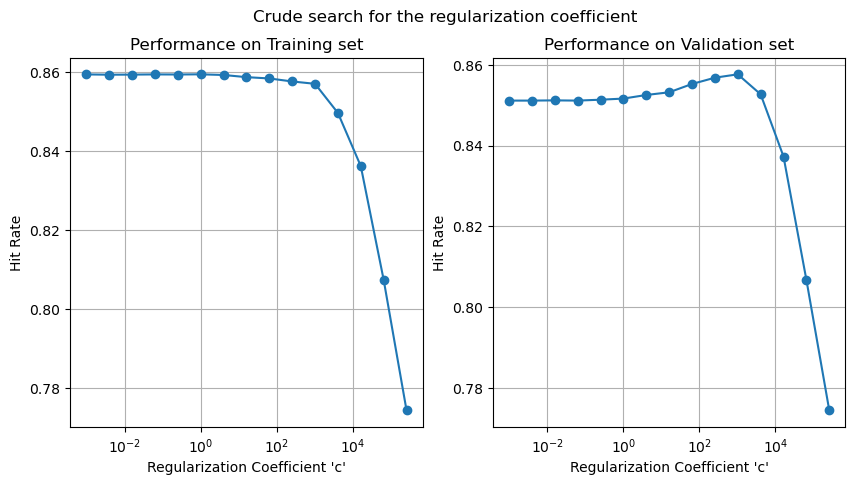

In [50]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))

<font color="green">
Atividade (a) <br>
Confira se o intervalo de excursão da busca está adequado. Justifique sua resposta. <br>
Caso não esteja, faça modificações pertinentes até encontrar um bom intervalo de busca. <br>
</font>

Resposta:
Sim, o intervalo sugerido já é capaz de maximizar a capacidade de generalização do modelo. Visualmente, quando tem-se um comportamento constante no começo da figura seguido de uma descida/cascata, provavelmente estamos em um intervalo onde há a melhor taxa de acertos (hit-rate) para o conjunto de dados. Para garantir, testou-se outros intervalos:
1. c_values = [pow(2,d) for d in range(0, 24, 2)] (deslocando-se para a direita), onde: "Best c value: 1024 Performance of this value: 0.8576111111111111"
2. c_values = [pow(2,d) for d in range(-5, 14, 2)] (deslocando-se para a esquerda), onde: "Best c value: 2048 Performance of this value: 0 8568333333333333"

Ou seja, tanto à esquerda quanto à direita, não há ganhos significativos na taxa de acertos.

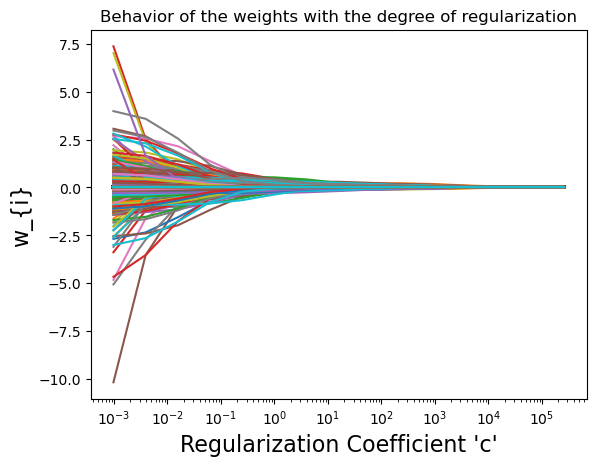

In [52]:
lambd_values = c_values
w_values = Ws
import numpy as np
import matplotlib.pyplot as plt

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=16)
    plt.ylabel(r"w_{i}", fontsize=16)
    plt.xscale("log")
    plt.title("Behavior of the weights with the degree of regularization")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [53]:
print("best_c (so far): ", best_c)
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_training, y_training, fine_c_values)

best_c (so far):  1024
256.0


640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


In [14]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_validation, y_validation, fine_c_values, Ws_fine)

256.0
640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


Best c value: 1024.0 
Performance of this value: 0.8553333333333333


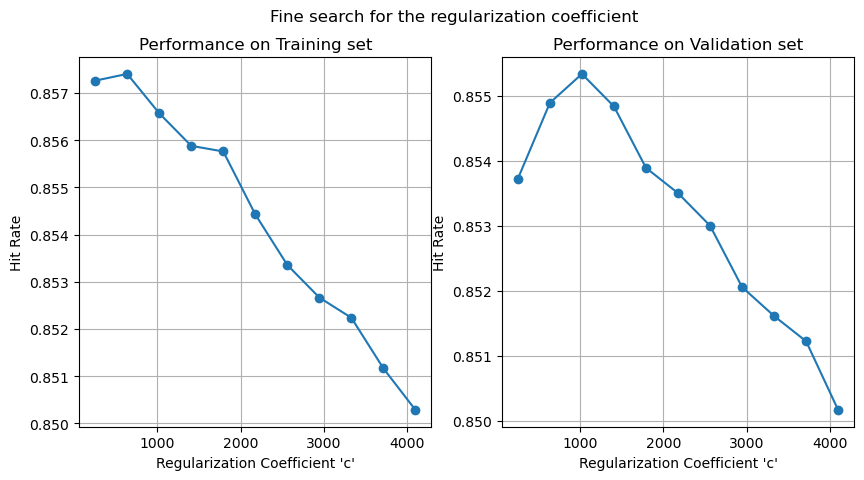

In [15]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [55]:
W = get_w(X, yy, best_c) # sets the final set of weights, considering the fine-tunned c_value, which is still 1024
print(W.shape)

(785, 10)


In [17]:
yt_estimate = np.matmul(Xt,W) 
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int) # rows (actual values), columns (predicted values)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8642


,0,1,2,3,4,5,6,7,8,9
0,940,0,18,5,1,21,15,5,13,19
1,0,1104,64,16,23,16,11,44,55,14
2,1,2,831,25,6,5,5,17,9,3
3,2,2,20,886,0,88,0,7,31,13
4,1,2,14,5,883,24,16,17,26,66
5,9,1,0,14,2,632,16,0,27,2
6,18,5,23,9,10,25,889,1,19,1
7,1,1,24,23,1,19,0,894,14,63
8,7,18,34,17,10,42,6,0,761,6
9,1,0,4,10,46,20,0,43,19,822


In [67]:
#print(confusion_matrix.shape[0])
#print(confusion_matrix.shape[1])

percentage_testing_data_hits = [float]*10

for i in range(confusion_matrix.shape[0]):
    sum_i = 0
    for j in range(confusion_matrix.shape[1]):
        if i != j:
            sum_i += confusion_matrix[i][j]
    percentage_testing_data_hits[i] = 1 - sum_i/confusion_matrix[i][i]
#print("percentage_testing_data_hits.shape: ", percentage_testing_data_hits.shape)
print("percentage hit for each value: ", percentage_testing_data_hits)

percentage hit for each value:  [0.8625277161862528, 0.8081936685288641, 0.856958762886598, 0.6580493537015276, 0.7805800756620429, 0.7730496453900709, 0.8329411764705883, 0.9045936395759717, 0.6409214092140921, 0.6670776818742293]


In [18]:
def f_score(confusion_matrix, betas):
    recall = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=0)
    precision = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=1)

    f_scores = np.zeros((len(betas), 10))

    for i, b in enumerate(betas):
        f_scores[i] = (1 + b**2) * precision * recall/(b**2 * precision + recall)

    return f_scores

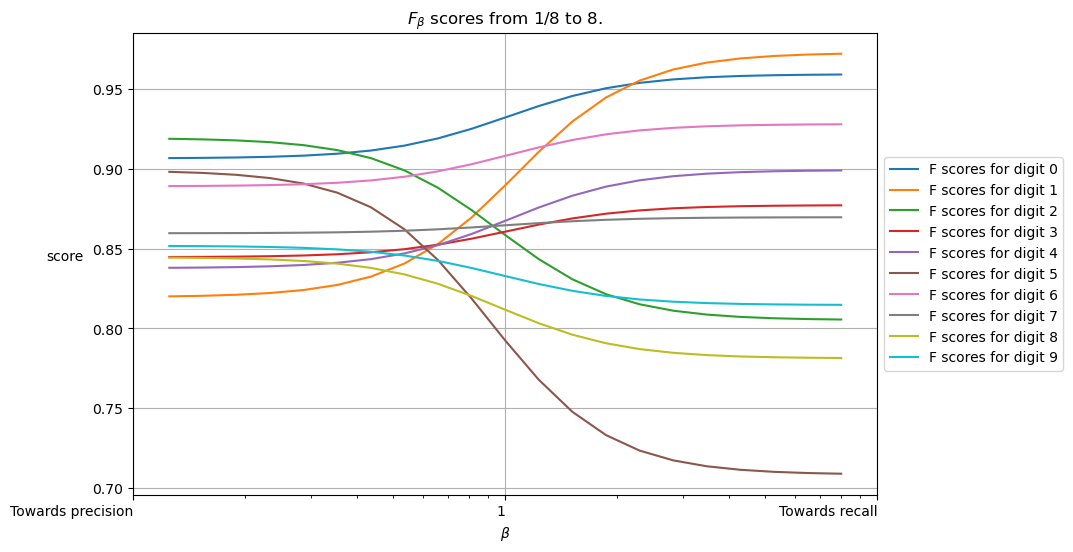

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

for i in range(10):
    plt.plot(np.logspace(-3, 3, base=2, num=21), f_score(confusion_matrix, np.logspace(-4, 4, base=2, num=21))[:, i], label=f"F scores for digit {i}")

ax.set_xlabel("$\\beta$")
ax.set_ylabel("score", rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xticks(np.geomspace(10**-1, 10**1 ,3), ["Towards precision", "1","Towards recall"], ha='right')
ax.grid()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.get_xaxis

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("$F_{\\beta}$ scores from 1/8 to 8.")

plt.show()

<font color="green">
Atividade (b) <br>
Indique quais são as duas classes mais desafiadoras para o classificador e qual o critério usado por você para chegar a esta conclusão. <br>
</font>

Resposta:


#### **Visualization of the 10 vectors of weights W, without the bias.**



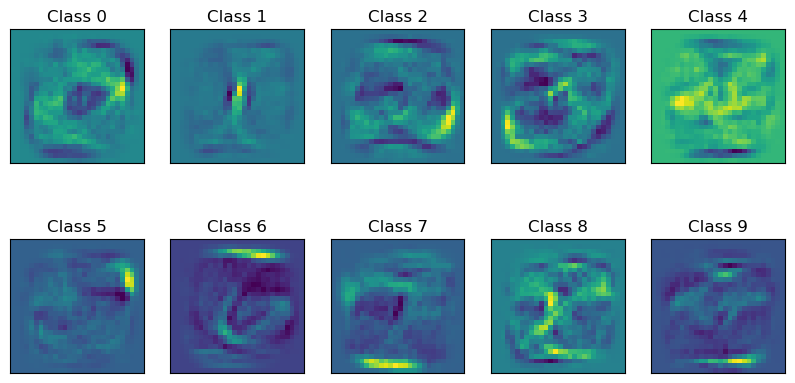

In [20]:
# Only for the MNIST dataset
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap='viridis')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### **To improve the visualization of the 10 vectors of weights W, the use of a divergent color map is indicated: the average value of the color map is a neutral color and the extreme values represent different colors. Using a divergent color map and a bilinear interpolation scheme (to facilitate the visualization of low-resolution images), the result of the visualization of the 10 vectors of weights W is illustrated in the following images.**

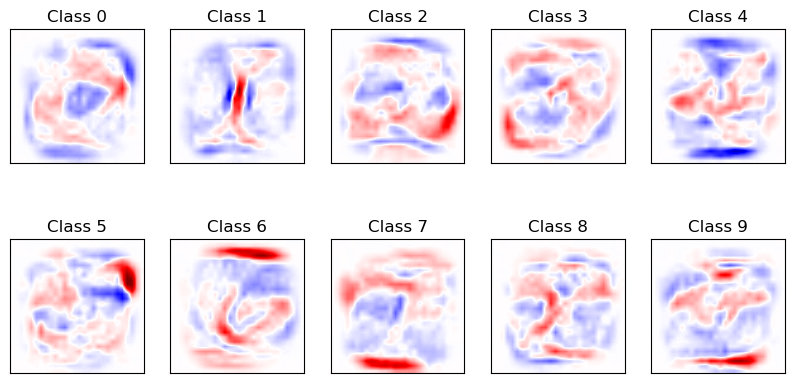

In [21]:
# Only for the MNIST dataset
scale = np.abs(W).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (c) <br>
Com base nesses dois resultados visuais acima, responda: Qual é a estratégia adotada pelo classificador linear para buscar máximo desempenho? <br>
</font>

Resposta:

#### **Performance of the average 10 vectors of weights (here no bias is considered)**

In [22]:
W1 = np.zeros((784, 10))
for i in range(10):
  aux = np.mean(Xp[y==i], axis=0)
  aux = aux.reshape(784)/255
  aux = aux-np.mean(aux)
  W1[:,i] = aux/np.sqrt(np.sum(np.square(aux)))
yt_estimate = np.matmul(Xta,W1)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8208


,0,1,2,3,4,5,6,7,8,9
0,902,0,27,6,4,27,29,8,7,16
1,0,1074,51,5,10,37,14,51,21,17
2,6,9,776,25,3,9,16,26,11,6
3,3,4,43,851,0,137,1,0,91,12
4,0,0,27,1,793,20,18,16,12,80
5,33,4,0,28,1,564,22,0,29,11
6,25,4,31,8,24,29,850,1,17,3
7,1,0,15,14,1,11,0,849,10,29
8,10,40,56,52,19,34,8,22,738,24
9,0,0,6,20,127,24,0,55,38,811


#### **Visualization of the average 10 vectors of weights**

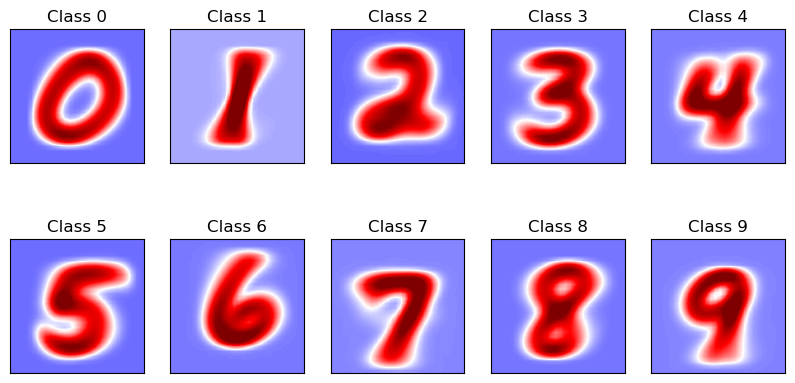

In [23]:
# Only for the MNIST dataset
scale = np.abs(W1).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W1[:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (d) <br>
Com base na execução das duas células acima, responda: Por que motivo os vetores com a média das imagens por classe não levam a um classificador de máximo desempenho? Nota: A resposta não depende do fato do classificador aqui não adotar o bias em sua implementação. <br>
</font>

Resposta:

Image no. 11


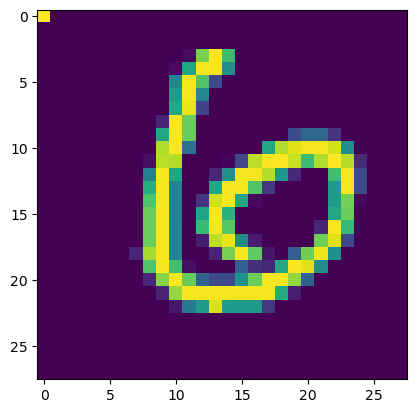

Real: 6
Predicted: 4
Rank of the correct answer: 6
Probabilities: [ 0.2344035   0.16069176  0.14971468  0.06913703  0.26389102 -0.17400486
  0.10095953 -0.07553308  0.17141296  0.05181571] 

Image no. 33


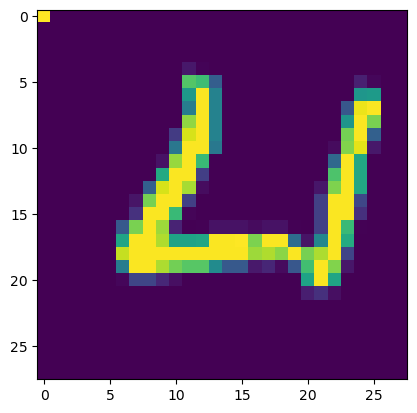

Real: 4
Predicted: 0
Rank of the correct answer: 4
Probabilities: [ 0.35845059 -0.08455628  0.1812747  -0.29922051  0.20366375  0.33781978
  0.22552617 -0.05079443  0.07592739 -0.04010936] 

Image no. 38


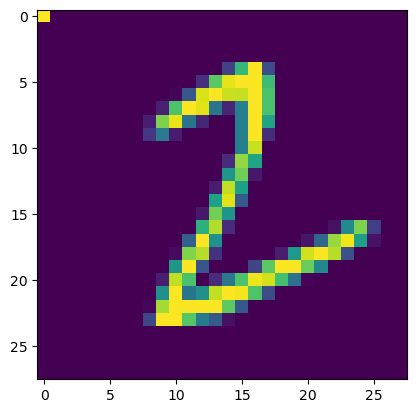

Real: 2
Predicted: 1
Rank of the correct answer: 5
Probabilities: [ 0.17249691  0.31698624  0.16484865  0.26119602 -0.28318569  0.08757432
  0.20884283 -0.05102544  0.12704516 -0.09350222] 

Image no. 43


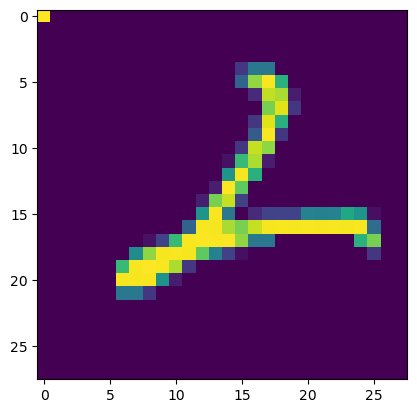

Real: 2
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.03469327  0.33227731  0.27943572  0.05419701  0.18465454  0.03928012
 -0.01111523 -0.04575413  0.13201297 -0.03458729] 

Image no. 45


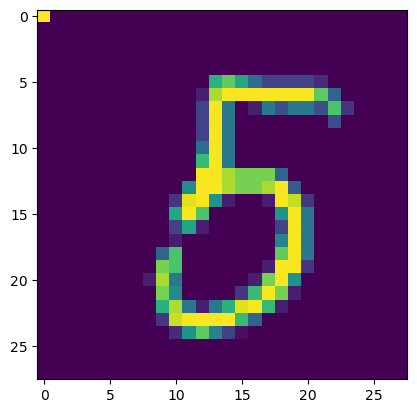

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.08727379 -0.12418142 -0.06194667  0.38226942  0.05653947  0.33789059
  0.17149562 -0.10338319  0.18624663 -0.01125874] 

Image no. 46


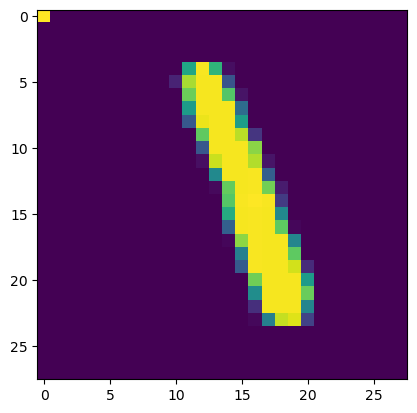

Real: 1
Predicted: 3
Rank of the correct answer: 2
Probabilities: [-0.27639744  0.31333585  0.14601131  0.33705365  0.07726481  0.19363085
  0.06894875  0.05522271 -0.00283716  0.07039978] 

Image no. 63


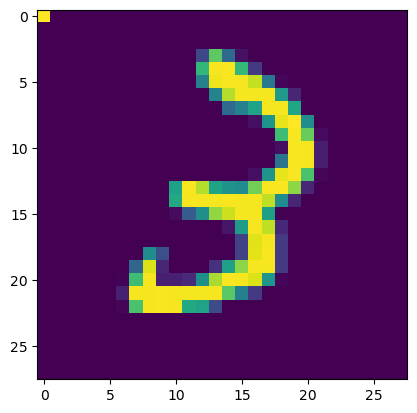

Real: 3
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.05063259  0.04588164  0.39904917  0.18717733  0.04060352 -0.01082341
 -0.02855646 -0.11580484  0.11012242  0.2805541 ] 

Image no. 66


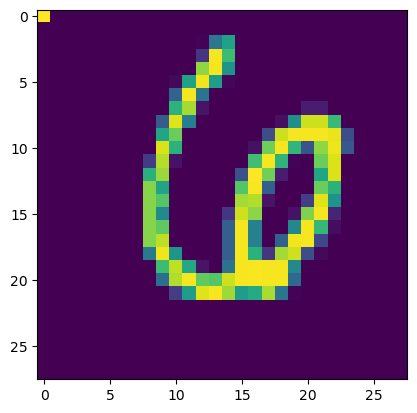

Real: 6
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.2156459   0.26985722  0.12385209  0.12443726  0.21578575 -0.09304025
  0.20129218  0.13814806 -0.08316641 -0.14394845] 

Image no. 77


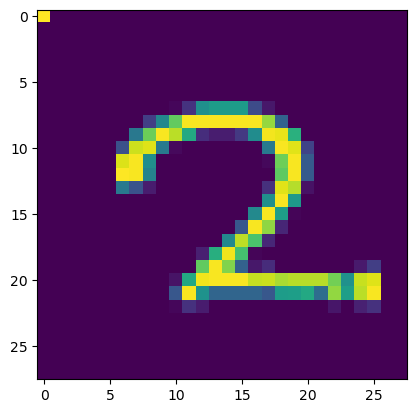

Real: 2
Predicted: 7
Rank of the correct answer: 2
Probabilities: [-0.0166231   0.09584678  0.39196455 -0.23724626  0.12517182  0.11163619
  0.07069253  0.41286161 -0.11696029  0.07467405] 

Image no. 80


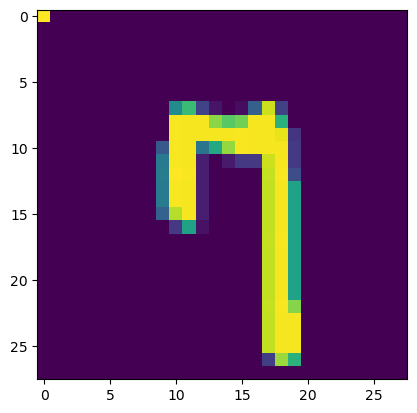

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.10781509 -0.13303982 -0.01190414  0.06044388  0.10069472  0.10019941
  0.00430467  0.44161806 -0.19434251  0.50942149] 

Image no. 92


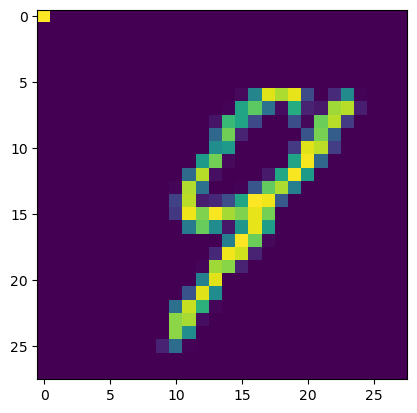

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.01491333  0.09968299  0.07817748 -0.02782986  0.25570433  0.05877023
  0.04344258  0.105886    0.085185    0.18575543] 

Image no. 97


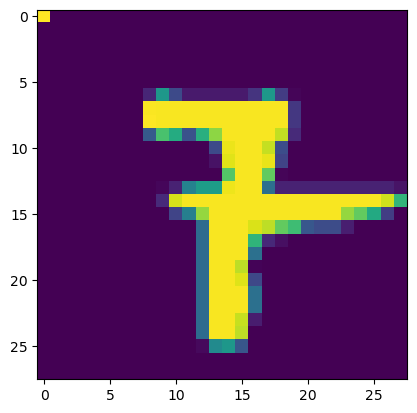

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.10859556  0.42963549 -0.15049236  0.20338289  0.14273784  0.00367364
  0.22254243  0.36102859 -0.01711557 -0.00275989] 

Image no. 111


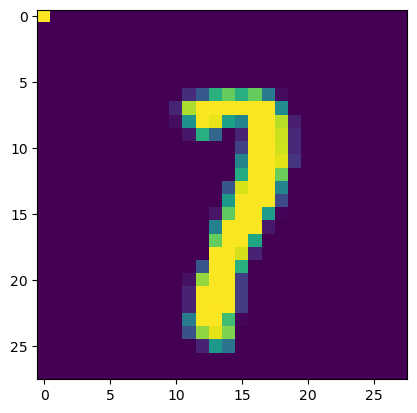

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.05950157  0.51291562  0.08376928  0.15744238 -0.0903743  -0.01337797
 -0.03162151  0.22523586  0.02893545  0.18489858] 

Image no. 124


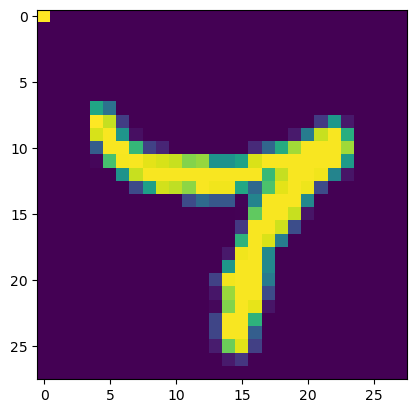

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.2234444   0.00794311 -0.24002489  0.16710828  0.38147653 -0.06748357
  0.0715589   0.3427552   0.27493831  0.27106622] 

Image no. 149


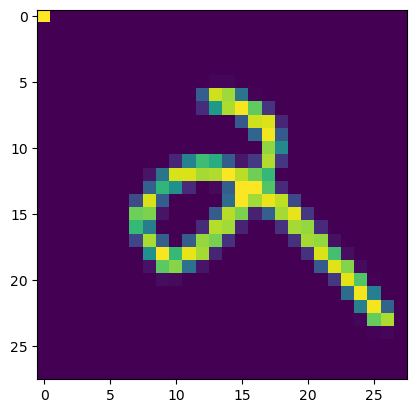

Real: 2
Predicted: 1
Rank of the correct answer: 4
Probabilities: [-0.01405083  0.26406973  0.09704728  0.04699957  0.20472764  0.05430158
  0.03932891 -0.14749582  0.09218502  0.26240422] 

Image no. 167


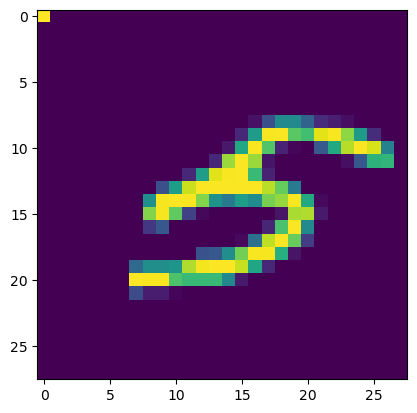

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.03666892  0.21142097  0.02565187  0.2875813   0.21562212  0.24789407
  0.00541988 -0.01713232 -0.02738404 -0.05335162] 

Image no. 187


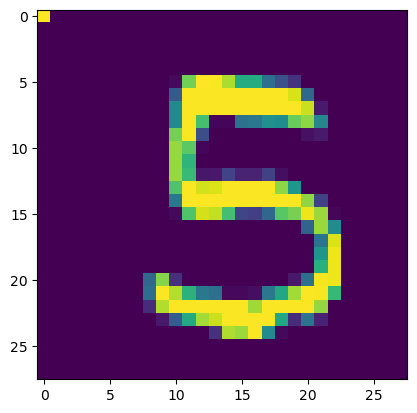

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.11333781 -0.04591545  0.11541755  0.38171485 -0.02827081  0.36768551
 -0.0959494  -0.20967416  0.17029475  0.19306254] 

Image no. 195


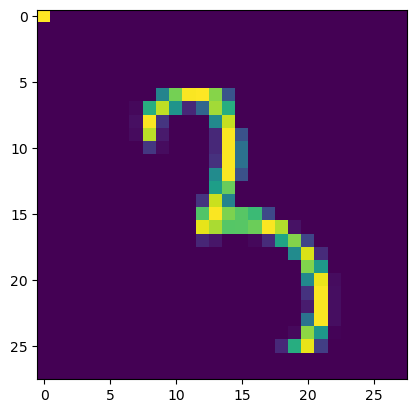

Real: 3
Predicted: 5
Rank of the correct answer: 3
Probabilities: [-0.12085922  0.00443375  0.07694146  0.13435959  0.08028235  0.21386106
  0.07809296  0.06363015  0.12357257  0.18208439] 



In [24]:
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(Xt,W)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

<font color="green">
Atividade (e) <br>
Informe o que faz esta última célula executável do notebook e analise os resultados obtidos logo acima. <br>
</font>

Resposta: